# GP2 Tutorial - Module 3 - How to Upload, Access, and Copy Over Data

`GP2 ❤️ Open Science 😍`

- **Module:** GP2 Demo
- **Authors:** Sara Bandres-Ciga, Hampton Leonard, and Mary Makarious on behalf of the Global Parkinson's Genetics Program
- **Estimated Computation and Runtime:** 
    - **Estimated Specifications:** Default; 1 CPU, 3.75 GB Memory, 50 GB Persistent Disk Size
    - **Estimated Runtime:** 20 min.
- **Date Last Updated:** 29-AUG-2022
    - **Update Description:** Updating notebook for GP2 release 2.0

---
### Quick Description
These notebooks serve as a beginner's introduction to Terra, GP2, and AMP-PD data to help you get comfortable navigating the spaces, manage your costs, upload your own data, and begin running some simple analyses.

### Course Summary
- **Module 1:** Intro + demo Terra 
- **Module 2:** Introduction to current AMP and GP2 data + managing costs
- **Module 3:** How to upload, access, and copy over data **(this notebook!)**
- **Module 4:** How to interact with clinical data + make mini covariate files
- **Module 5:** Analysis example 1: Run PRS with PD known hits in Non-Euro pops and data viz + save results
- **Module 6:** Analysis example 2: How to extract a gene, annotate it, run burden, and get hmz and compound hets + save results
- **Module 7:** WDL workflows: What they are + When to use + Quick example overview
--- 
## Notebook Summary 
- Getting Started
- Data Overview
- How to Upload to Workspace Bucket
- How to Access AMP-PD Data
- How to Access GP2 Data

## Workflow

### [Getting Started](#1)
This section goes through: 
- Functions needed to interact between Terra and the cloud

### [Data Overview](#2)
This section goes through:
- Quick overview access AMP-PD data
- Quick overview of GP2 data

### [How to Upload to Workspace Bucket](#3)
This section goes through:
- How to upload to your Workspace Bucket
- How to copy files from your Workspace Bucket to your VM

### [How to Access and Copy Over AMP-PD Data](#4)
This section goes through:
- Overview of what's availabe on AMP
- How to load different data

### [How to Access and Copy Over GP2 Data](#5)
This section goes through:
- Overview of what's availabe on AMP
- How to load different data


---
<a id="1"></a>
# Getting Started 

## Load Libraries

In [1]:
# Use the os package to interact with the environment
import os
import sys

# Bring in Pandas for Dataframe functionality
import pandas as pd
from functools import reduce

# Bring some visualization functionality 
import seaborn as sns

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

## Create Python functions to interact with GCP/Terra
Terra is an intermediate platform, designed to help the user interact with the data placed in Google Cloud buckets.

In [2]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

## Initialize Workspace Variables

In [3]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v2.5')
print(f'Path to AMP-PD v2.5 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v2.5 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

## GP2 v2.0
## Explicitly define release v2.0 path 
GP2_RELEASE_PATH = 'gs://gp2tier2/release2_06052022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v2.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

Billing and Workspace
Workspace Name: GP2 Bioinformatics Course 2
Billing Project: terra-9b559320
Workspace Bucket, where you can upload and download data: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914

AMP-PD v2.5
Path to AMP-PD v2.5 Clinical Data: gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
Path to AMP-PD v2.5 WGS Data: gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink

GP2 v2.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release2_06052022/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release2_06052022/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release2_06052022/imputed_genotypes


---
<a id="2"></a>
# Data Overview

### Paths to AMP-PD Buckets 
From AMP-PD's Getting Started workspaces

Raw files are stored in [Google Cloud Storage](https://cloud.google.com/storage/) buckets:

- [gs://amp-pd-data](https://console.cloud.google.com/storage/browser/amp-pd-data): Clinical data files and other participant metadata
- [gs://amp-pd-data-tier2](https://console.cloud.google.com/storage/browser/amp-pd-data-tier2): Clinically reported genetic mutations and other restricted-access participant metadata
- [gs://amp-pd-genomics](https://console.cloud.google.com/storage/browser/amp-pd-genomics): Whole Genome sequencing CRAMs, VCFs, and metrics files
- [gs://amp-pd-transcriptomics](https://console.cloud.google.com/storage/browser/amp-pd-transcriptomics): Transcriptomics FASTQs, BAMs, Quantification, and Feature Counts files for single samples and QC pools
- [gs://amp-pd-proteomics](https://console.cloud.google.com/storage/browser/amp-pd-proteomics): Proteomics preview release with eight unfiltered NPX files from four separate assays for matched Plasma and CSF samples
- More information here: https://amp-pd.org/data 
        
### AMP-PD Bucket Structure - Overview

In Tier 2, the structure looks like the following
```
{GS_RELEASE_PATH} @ gs://amp-pd-data/releases/2021_v2-5release_0510
    ├── amp_pd_case_control.csv
    ├── amp_pd_participant_wgs_duplicates.csv
    ├── amp_pd_participants.csv
    ├── rna_sample_inventory.csv
    ├── wgs_gatk_joint_genotyping_samples.csv
    ├── wgs_sample_inventory.csv
    └── clinical/
            └── [58 files]
```


### Paths to GP2 Buckets (Release 2)

Raw files are stored in [Google Cloud Storage](https://cloud.google.com/storage/) buckets:

#### Tier 1 
- [gs://gp2_tier1/release2_06052022](https://console.cloud.google.com/storage/browser/gp2tier1/release2_06052022): Tier 1 Bucket
- [gs://gp2_tier1/release2_06052022/summary_statistics/](https://console.cloud.google.com/storage/browser/gp2_tier1/release2_06052022/summary_statistics): Summary statistics 

#### Tier 2 
- [gs://gp2_tier2/release2_06052022/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/): Tier 2 bucket
- [gs://gp2_tier2/release2_06052022/summary_statistics/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/summary_statistics): Summary statistics 
- [gs://gp2_tier2/release2_06052022/raw_genotypes/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/raw_genotypes): Raw genotypes (PLINKv2 files - pgen files broken down by ancestry)
- [gs://gp2_tier2/release2_06052022/imputed_genotypes/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/imputed_genotypes): Imputed genotypes (PLINKv2 files - pgen files broken down by ancestry)
- [gs://gp2_tier2/release2_06052022/cnvs/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/cnvs): Probabilistic estimates of copy number variation per gene 
- [gs://gp2_tier2/release2_06052022/clinical_data/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/clinical_data/): Clinical data and dictionary 
- [gs://gp2_tier2/release2_06052022/meta_data/](https://console.cloud.google.com/storage/browser/gp2_tier2/release2_06052022/meta_data): Meta data (hdf5 file with QC, ancestry, principle components, etc)

### GP2 Bucket Structure - Overview

```
gp2_tier1
	└── summary_statistics/

gp2_tier2
	├── raw_genotypes/
	├── imputed_genotypes/
	├── cnvs/
	├── meta_data/
	├── clinical_data/
	└── summary_statistics/
```

**for more information, please see Modules 1 and 2 in this series!**

---
<a id="3"></a>
#  How to Upload to Workspace Bucket

If you need external data for your analyses, it's easy to upload and copy these files to your VM.

In your workspace, navigate to the 'Data' tab and then the 'Files' tab | Then click the blue plus sign button on the bottom right to bring up your computer's file manager
--- | ---
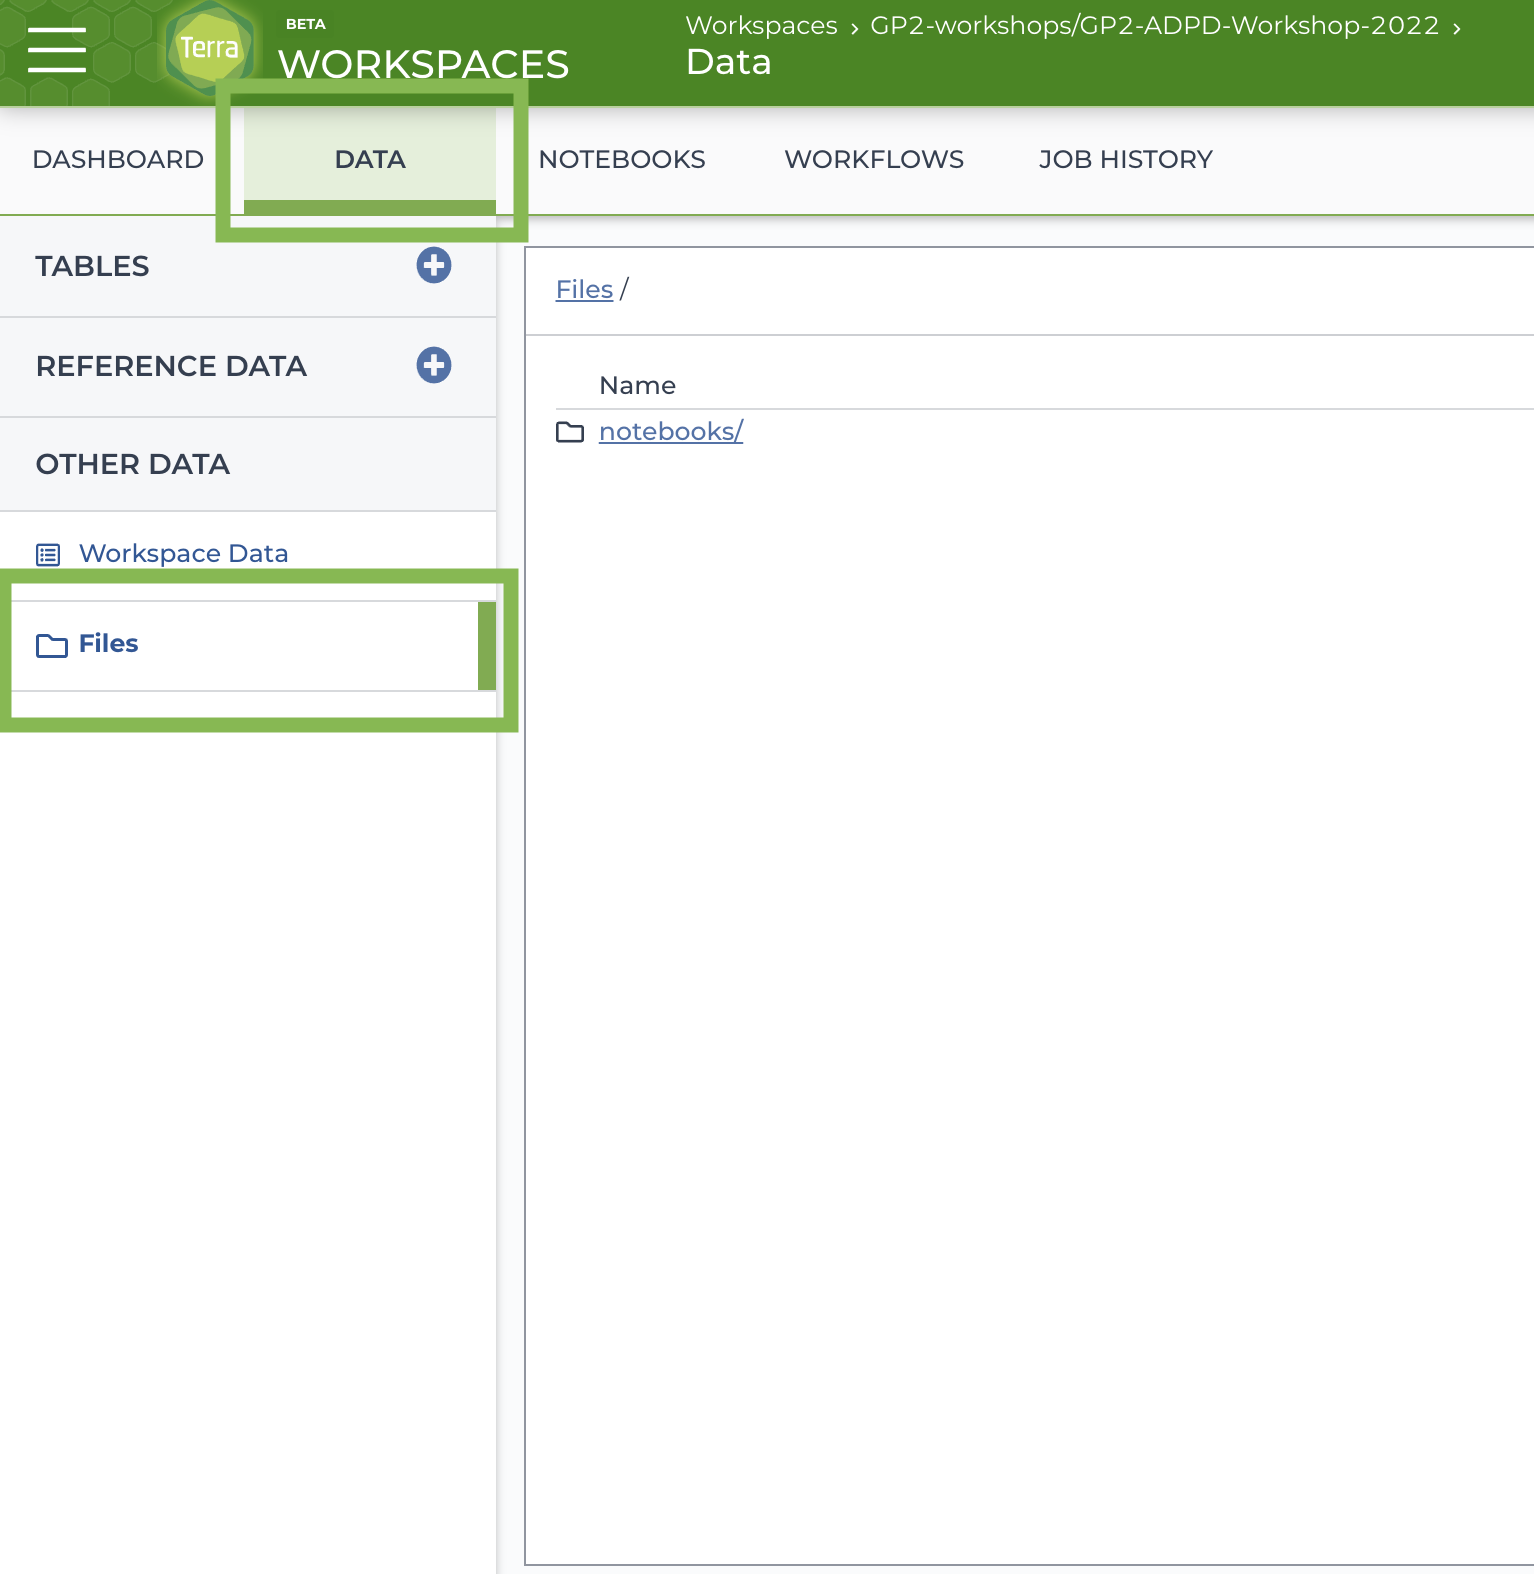 | 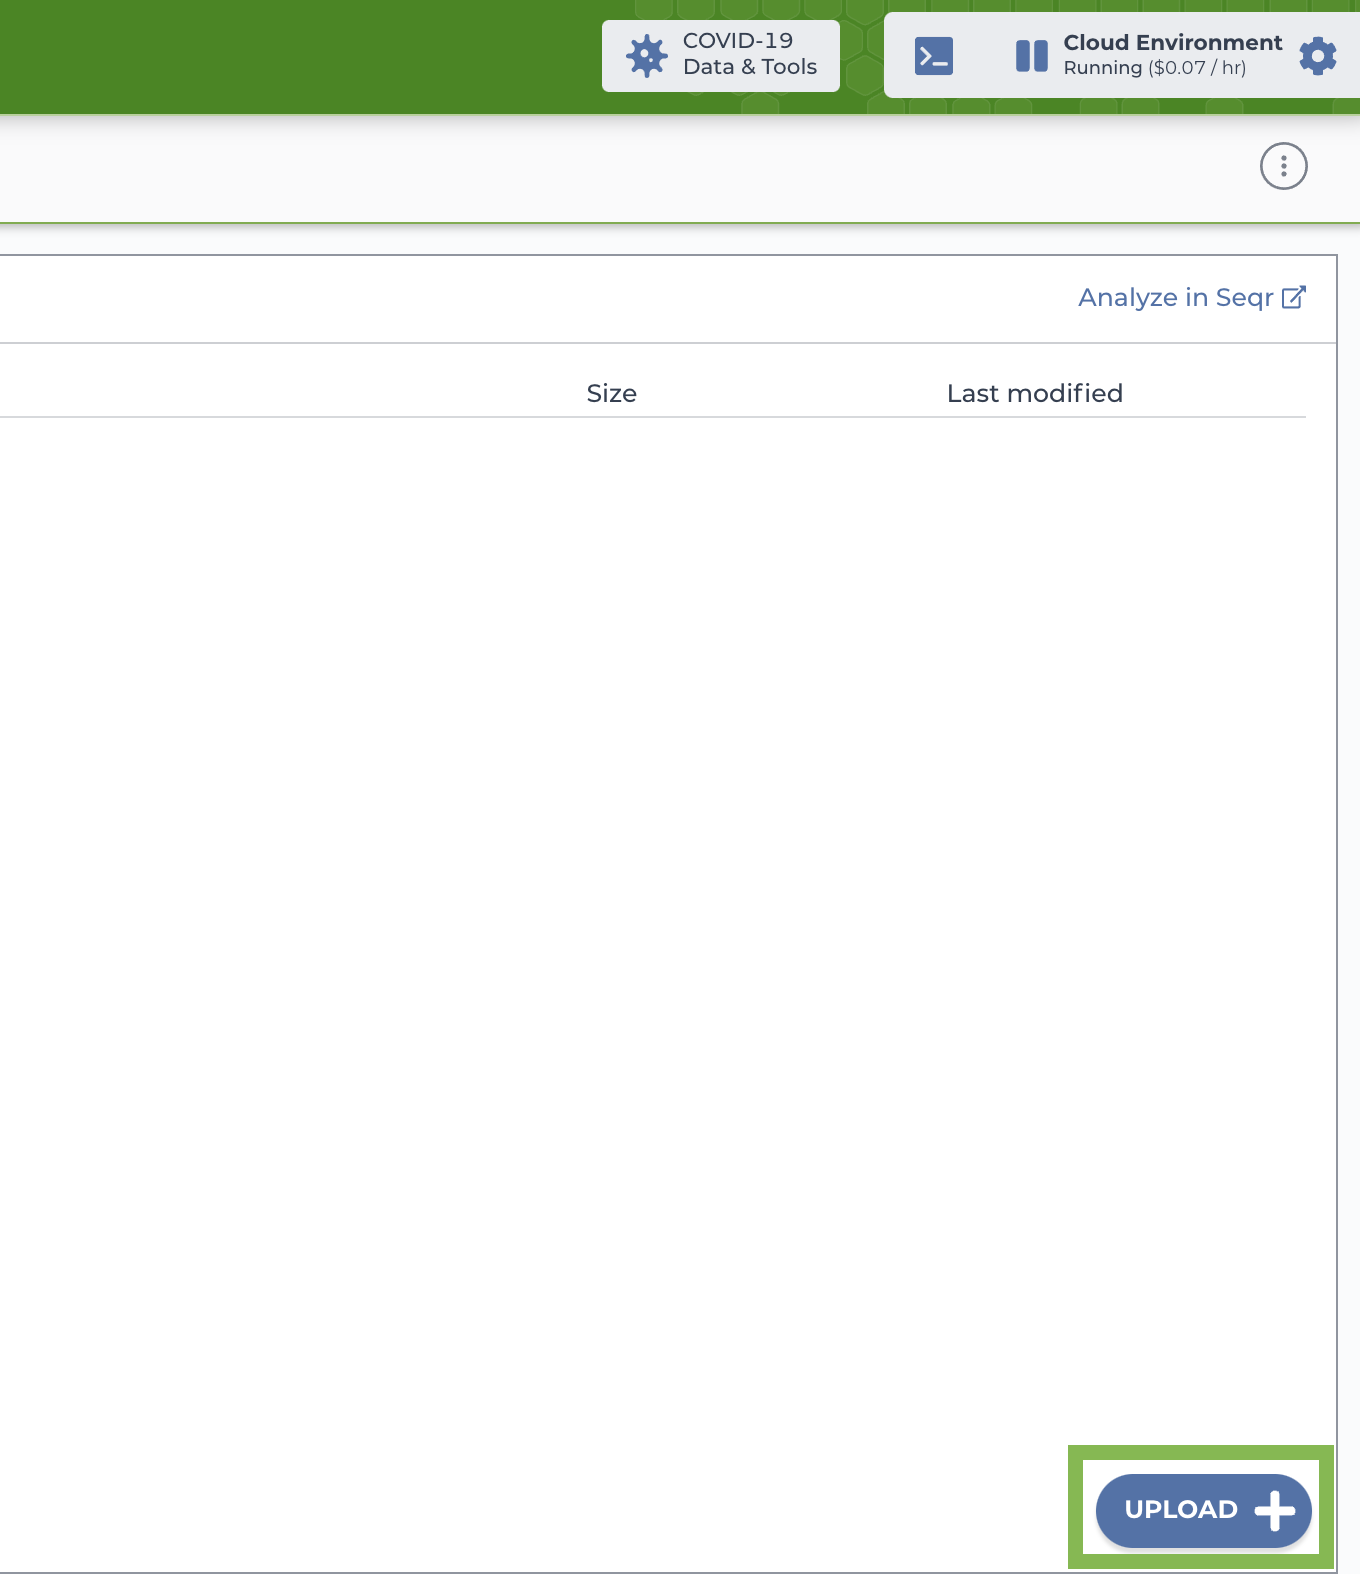

You can also download files from the same interface!

Once you have uploaded data, you will need to copy it from your workspace bucket (where uploaded and written files are stored) to your VM. If you use the 'Initialize Workspace Variables' code cell above, it will automatically pull and store the location of your workspace bucket.

You can also find the location of your workspace bucket by going to the 'Dashboard' in your workspace and looking for the 'Google Bucket' information on the right.

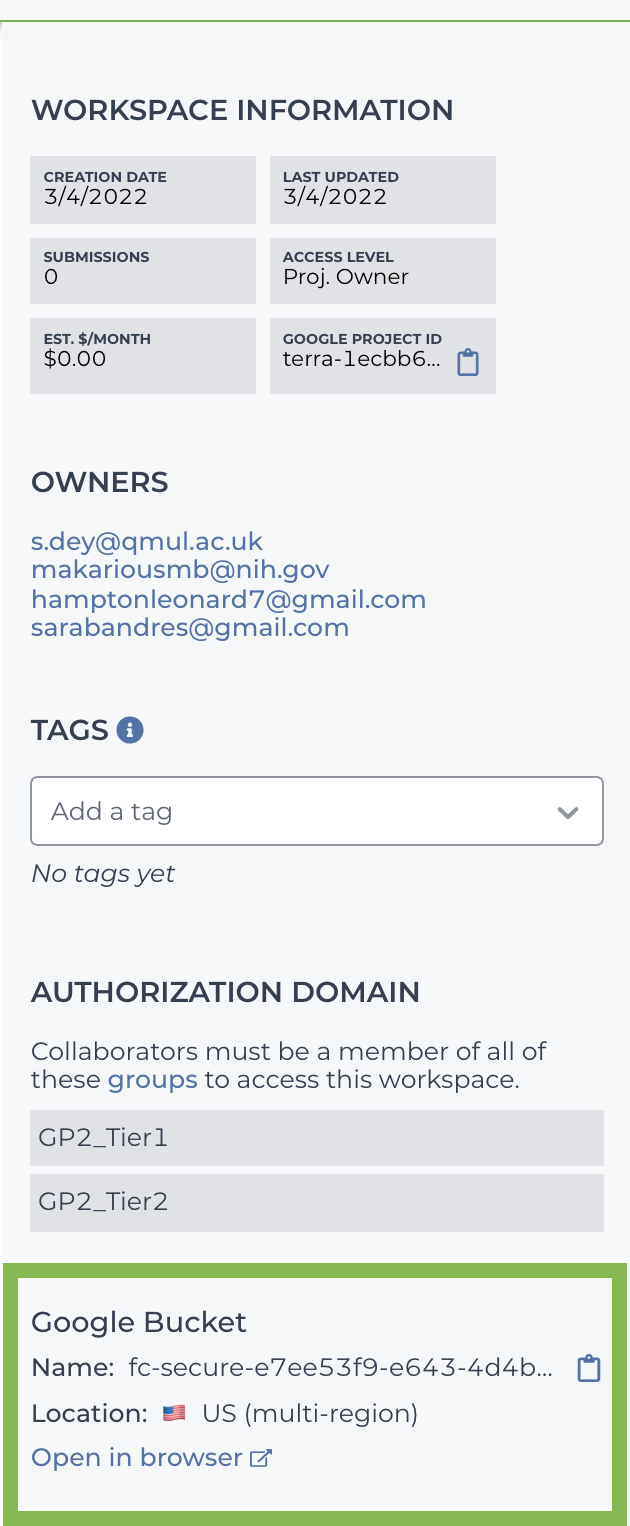

You can move files from this location to your VM by using the command below.

In [4]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'/home/jupyter/{WORKSPACE_NAME}_demo/eQTL_data/'
shell_do(f'mkdir -p {WORK_DIR}')

# Move the eQTL data that was uploaded to your VM
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {WORKSPACE_BUCKET}/psychencode_workshop_snippet.txt {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/GP2 Bioinformatics Course 2_demo/eQTL_data/
Executing: gsutil -u terra-9b559320 -m cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/psychencode_workshop_snippet.txt /home/jupyter/GP2 Bioinformatics Course 2_demo/eQTL_data/


CommandException: No URLs matched: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/psychencode_workshop_snippet.txt
Omitting directory "file:///home/jupyter/GP2". (Did you mean to do cp -r?)
Omitting directory "file://Bioinformatics". (Did you mean to do cp -r?)
Omitting directory "file://Course". (Did you mean to do cp -r?)
CommandException: 1 file/object could not be transferred.


Adding a `%%bash` at the top of your cell or `!` before a command tells your notebook to run the code as a bash command. This is an another way other than the `shell_do` function to run shell commands. You can use this to run shell scripts or quickly look at the files you've moved to your VM.

Take a look and see that our file copied over.

In [5]:
%%bash -s "$WORK_DIR"

head $1/psychencode_workshop_snippet.txt

==> /home/jupyter/GP2 <==

==> Bioinformatics <==

==> Course <==


head: error reading '/home/jupyter/GP2': Is a directory
head: error reading 'Bioinformatics': Is a directory
head: error reading 'Course': Is a directory
head: cannot open '2_demo/eQTL_data//psychencode_workshop_snippet.txt' for reading: No such file or directory


CalledProcessError: Command 'b'\nhead $1/psychencode_workshop_snippet.txt\n'' returned non-zero exit status 1.

You can also check the file like this.

In [ ]:
shell_do(f' head {WORK_DIR}/psychencode_workshop_snippet.txt')

---
<a id="4"></a>
#  How to Access and Copy Over AMP-PD Data

We need to copy over data from buckets to our workspace in order to start working with it.

For this AMP-PD example, we will be copying over clinical data made available in their Tier 1 buckets. AMP-PD has several clinical files.

**WARNING!** This VM, when deleted, deletes all data copied over to it! It is only intended to be a _temporary_ storage.

If you want to store results or files long-term, copy them to your own workspace bucket bucket (more in Modules 5 and 6)

In [12]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'/home/jupyter/{WORKSPACE_NAME}_demo/AMP_COV_FILE/'
shell_do(f'mkdir -p {WORK_DIR}')

# Check directories where AMP-PD data are 
print("List available information in AMP-PD")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {AMP_RELEASE_PATH}')

print("List available clinical information in AMP-PD")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {AMP_CLINICAL_RELEASE_PATH}')

Making a working directory


Executing: mkdir -p /home/jupyter/GP2 Bioinformatics Course 2_demo/AMP_COV_FILE/


List available information in AMP-PD


Executing: gsutil -u terra-9b559320 ls gs://amp-pd-data/releases/2021_v2-5release_0510


gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_participant_wgs_duplicates.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_participants.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/rna_sample_inventory.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/wgs_gatk_joint_genotyping_samples.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/wgs_sample_inventory.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/
List available clinical information in AMP-PD


Executing: gsutil -u terra-9b559320 ls gs://amp-pd-data/releases/2021_v2-5release_0510/clinical


gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_SomaLogic_plasma.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_SomaLogic_plasma_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_other.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_other_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Caffeine_history.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Caffeine_history_dictiona

As you can see...
- AMP keeps the phenotype information in a different bucket `{AMP_RELEASE_PATH}/amp_pd_case_control.csv`
- there's a variety of information captured in `{AMP_CLINICAL_RELEASE_PATH}` like demographic information, UPDRS scores, RBD Questionnaire, DaTSCAN... we will just copy over demographic information

In [13]:
# An example to copy files to your from your bucket workspace to your notebook workspace
print("Copy over files from bucket to VM workspace")
print("WARNING! This VM, when deleted, deletes all data copied over to it")
print("If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)")

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_RELEASE_PATH}/amp_pd_case_control.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_CLINICAL_RELEASE_PATH}/Enrollment.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_CLINICAL_RELEASE_PATH}/Demographics.csv {WORK_DIR}')

Copy over files from bucket to VM workspace
WARNING! This VM, when deleted, deletes all data copied over to it
If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv /home/jupyter/GP2 Bioinformatics Course 2_demo/AMP_COV_FILE/


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv...
/ [1/1 files][732.1 KiB/732.1 KiB] 100% Done                                    
Operation completed over 1 objects/732.1 KiB.                                    


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Enrollment.csv /home/jupyter/GP2 Bioinformatics Course 2_demo/AMP_COV_FILE/


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Enrollment.csv...
/ [1/1 files][632.4 KiB/632.4 KiB] 100% Done                                    
Operation completed over 1 objects/632.4 KiB.                                    


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Demographics.csv /home/jupyter/GP2 Bioinformatics Course 2_demo/AMP_COV_FILE/


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Demographics.csv...
/ [1/1 files][635.3 KiB/635.3 KiB] 100% Done                                    
Operation completed over 1 objects/635.3 KiB.                                    


In the next modules we will go over a few things you can do once you've copied over the data you need :) 

---
<a id="5"></a>
#  How to Access and Copy Over GP2 Data
Same idea here, we need to copy data over from the bucket to our VM before we can do any analysis or manipulation.

For this GP2 example, we will be copying over European imputed genotypes and the clinical data file. GP2 only has one clinical file so far.

**WARNING!** This VM, when deleted, deletes all data copied over to it! It is only intended to be a _temporary_ storage.

If you want to store results or files long-term, copy them to your own workspace bucket bucket (more in Modules 5 and 6)

In [14]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'/home/jupyter/{WORKSPACE_NAME}_demo/LRRK2_GBA/'
shell_do(f'mkdir -p {WORK_DIR}')

# Check directory where GP2 Tier 2 data is
print("List available imputed genotype information in GP2 (broken down by ancestry)")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_IMPUTED_GENO_PATH}')

Making a working directory


Executing: mkdir -p /home/jupyter/GP2 Bioinformatics Course 2_demo/LRRK2_GBA/


List available imputed genotype information in GP2 (broken down by ancestry)


Executing: gsutil -u terra-9b559320 ls gs://gp2tier2/release2_06052022/imputed_genotypes


gs://gp2tier2/release2_06052022/imputed_genotypes/AAC/
gs://gp2tier2/release2_06052022/imputed_genotypes/AFR/
gs://gp2tier2/release2_06052022/imputed_genotypes/AJ/
gs://gp2tier2/release2_06052022/imputed_genotypes/AMR/
gs://gp2tier2/release2_06052022/imputed_genotypes/CAS/
gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/
gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/
gs://gp2tier2/release2_06052022/imputed_genotypes/SAS/


In [ ]:
# An example to copy files to your from your bucket workspace to your notebook workspace
print("Copy over files from bucket to VM workspace")
print("WARNING! This VM, when deleted, deletes all data copied over to it")
print("If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)")

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_IMPUTED_GENO_PATH}/EUR {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_CLINICAL_RELEASE_PATH}/master_key_release1.csv {WORK_DIR}')

Copy over files from bucket to VM workspace
WARNING! This VM, when deleted, deletes all data copied over to it
If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)


Executing: gsutil -u terra-9b559320 -m cp -r gs://gp2tier2/release2_06052022/imputed_genotypes/EUR /home/jupyter/GP2 Bioinformatics Course 2_demo/LRRK2_GBA/


Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr10_EUR_release2.log...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr10_EUR_release2.pgen...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr10_EUR_release2.psam...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr11_EUR_release2.log...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr11_EUR_release2.pgen...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr10_EUR_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr11_EUR_release2.psam...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr11_EUR_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr12_EUR_release2.psam...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr12_EUR_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/chr12_EUR_release2.pgen...
Copying gs://gp2tier2/r

In the next modules we will go over a few things you can do once you've copied over the data you need :) 